<a target="_blank" href="https://colab.research.google.com/github/dreonic/NTU-SC3000-Cartpole/blob/main/cartpole_monte_carlo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Balancing a Pole on a Cart

## Installing dependencies:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

## Importing dependencies and define helper functions

In [1]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from collections import defaultdict

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

rng = np.random.default_rng()

## Tutorial: Loading CartPole environment

In [2]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [3]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [4]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [5]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [-0.03362356  0.01607564 -0.01777277 -0.02917122]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [6]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [-0.03330204 -0.178787   -0.01835619  0.25785163]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [7]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 9.0


## Task 1: Development of an RL agent

We implement a reinforcement learning agent utilizing a Monte Carlo method.

### State Quantization

Since the CartPole environment's state is continuous, it will result in an infinite amount of value function for each state. Hence, we reduce the state size by quantizing its state into discrete values.

We define a function which divides a continuous range [`min_val`, `max_val`] into `n` bins.

In [8]:
def get_bins(min_val, max_val, n):
    bins = []
    step = (max_val - min_val) / (n - 1)
    while min_val < max_val:
        bins.append(min_val)
        min_val += step
    bins.append(max_val)
    return np.array(bins)

We create two bins, each containing 20 bins:
1. `cart_bins` is the bins for cart position ([-4.8, 4.8]) and cart velocity ($(-\infty,\infty)$).
2. `pole_bins` is the bins for pole angle ([-0.418 rad, 0.418 rad]) and pole angular velocity $(-\infty,\infty)$.

In [9]:
cart_bins = get_bins(-4.8, 4.8, 20)
pole_bins = get_bins(-0.418, 0.418, 20)

We write a function to quantize a CartPole environment's state.

In [10]:
def quantize_cartpole(state):
    return (np.digitize([state[0]], cart_bins)[0],
            np.digitize([state[1]], cart_bins)[0],
            np.digitize([state[2]], pole_bins)[0],
            np.digitize([state[3]], pole_bins)[0],)

### Implementation of the Monte Carlo method

We use an on-policy first-visit Monte Carlo control algorithm for $\varepsilon$-soft policies.

In [11]:
class MonteCarloControl:
    def __init__(self, env, quantize_func, gamma=1.0, epsilon=0.05):
        self.env = env
        # state quantization function
        self.quantize_func = quantize_func
        # discount rate
        self.gamma = gamma
        # probability of choosing a non-optimal action
        self.epsilon = epsilon
        # cardinality of the action set
        self.nA = self.env.action_space.n
        # the approximate value function
        self.Q = defaultdict(lambda: np.zeros(self.nA))
    
    def get_probabilities(self, state):
        Qs = self.Q[state]
        policy_s = np.ones(self.nA) * self.epsilon / self.nA
        best_a = np.argmax(Qs)
        policy_s[best_a] = 1 - self.epsilon + self.epsilon / self.nA
        return policy_s
    
    def generate_episode(self):
        episode = []
        state = self.env.reset()
        done = False
        while not done:
            quantized_state = self.quantize_func(state)
            action = rng.choice(
                np.arange(self.nA),
                p=self.get_probabilities(quantized_state)) \
                if quantized_state in self.Q else self.env.action_space.sample()
            next_state, reward, done, info = self.env.step(action)
            episode.append((quantized_state, action, reward))
            state = next_state
        return episode
    
    # updates Q, returns_sum, and visits
    def update_values(self, episode, returns_sum, visits):
        states, actions, rewards = zip(*episode)
        # state-action pairs
        sa_pairs = zip(states, actions)
        discounts = np.array([self.gamma ** i for i in range(len(rewards) + 1)])
        for i, sa_pair in enumerate(sa_pairs):
            state, action = sa_pair
            visits[state][action] += 1
            returns_sum[state][action] += sum(rewards[i:] * discounts[:-(1+i)])
            self.Q[state][action] = \
                returns_sum[state][action] / visits[state][action]
        return returns_sum, visits
    
    # approximate the value function Q and plicy
    def solve(self, num_eps):
        # the sum of returns for each state-action pair first occurrence
        returns_sum = defaultdict(lambda: np.zeros(self.nA))
        # the number of visits to each state-action pair
        visits = defaultdict(lambda: np.zeros(self.nA))
        for ep_num in range(1, num_eps + 1):
            if (100 * ep_num / num_eps) % 10 == 0:
                print(f"{100 * ep_num / num_eps}% completed...")
            episode = self.generate_episode()
            returns_sum, visits = self.update_values(episode, returns_sum, visits)
    
    # obtain the state-action value function
    def get_Q(self):
        return self.Q
    
    # obtain policy pi from state-action value function Q
    def get_policy(self):
        policy = defaultdict(int)
        for state, action_values in self.Q.items():
            policy[state] = np.argmax(action_values)
        return policy
    
    def get_agent(self):
        policy = self.get_policy()
        def agent(observation):
            quantized_state = self.quantize_func(observation)
            return policy[quantized_state]
        return agent

In [12]:
mc_control = MonteCarloControl(env, quantize_cartpole, 1, 0.05)
mc_control.solve(2000)
mc_policy_agent = mc_control.get_agent()

10.0% completed...
20.0% completed...
30.0% completed...
40.0% completed...
50.0% completed...
60.0% completed...
70.0% completed...
80.0% completed...
90.0% completed...
100.0% completed...


For Task 1, we can show the observation and chosen action below:

In [13]:
observation = env.reset()
action = mc_policy_agent(observation)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [-0.01439265 -0.03045272 -0.04464487  0.0055473 ]
Chosen action: 0


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

In [14]:
results_list = []
for _ in range(100):
    observation = env.reset()
    cumulative_reward = 0
    done = False
    while not done:
        action = mc_policy_agent(observation)
        observation, reward, done, info = env.step(action)
        cumulative_reward += reward
    results_list.append(cumulative_reward)

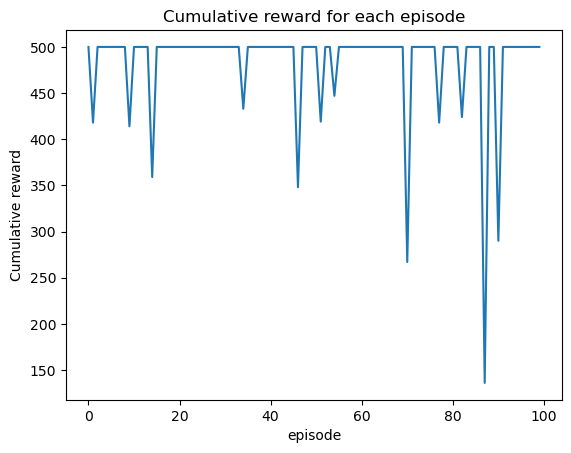

In [15]:
episode_results = np.array(results_list)
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [16]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 483.73
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [17]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    action = mc_policy_agent(observation)
    observation, reward, done, info = env.step(action) 
    if done: 
      break;    
env.close()
show_video()